<a href="https://colab.research.google.com/github/inesamorim/Counterfactual-Fairness-in-Health-Prediction-Models-under-Data-Imbalance/blob/main/main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<div align="center">
    
---
# Title Here
</div>

---
## Problem Context
---

text

---
## Data Source
---

Text

---
## Module Imports
---

In [1]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
!git clone https://github.com/inesamorim/Counterfactual-Fairness-in-Health-Prediction-Models-under-Data-Imbalance.git /content/drive/MyDrive/Counterfactual-Fairness-in-Health-Prediction-Models-under-Data-Imbalance

# Then just link it to the current working directory
%cd /content/drive/MyDrive/Counterfactual-Fairness-in-Health-Prediction-Models-under-Data-Imbalance

/content/drive/MyDrive/Counterfactual-Fairness-in-Health-Prediction-Models-under-Data-Imbalance


In [ ]:
#%reload_ext autoreload
#%autoreload 2

In [1]:
from google.colab import output
output.enable_custom_widget_manager()

In [2]:
import os
os.chdir('/content/drive/MyDrive/Counterfactual-Fairness-in-Health-Prediction-Models-under-Data-Imbalance')

In [9]:
%pip install -r "./requirements.txt"

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 162.1/162.1 kB 3.3 MB/s eta 0:00:00
  Attempting uninstall: protobuf
    Found existing installation: protobuf 3.20.0
    Uninstalling protobuf-3.20.0:
      Successfully uninstalled protobuf-3.20.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow-metadata 1.17.2 requires protobuf>=4.25.2; python_version >= "3.11", but you have protobuf 3.20.3 which is incompatible.
grpcio-status 1.71.2 requires protobuf<6.0dev,>=5.26.1, but you have protobuf 3.20.3 which is incompatible.
opentelemetry-proto 1.37.0 requires protobuf<7.0,>=5.0, but you have protobuf 3.20.3 which is incompatible.
ydf 0.13.0 requires protobuf<7.0.0,>=5.29.1, but you have protobuf 3.20.3 which is incompatible.


In [3]:
from ucimlrepo import fetch_ucirepo #load the function to fetch datasets from UCI ML Repository
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from utils import *  #import all functions from utils.py
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
from imblearn.over_sampling import SMOTE
from witwidget.notebook.visualization import WitConfigBuilder, WitWidget

In [ ]:
framingham_df = pd.read_csv('datasets/framingham.csv')
framingham_df.head()

In [12]:
# fetch dataset
heart_disease = fetch_ucirepo(id=45)


In [13]:
# data (as pandas dataframes)
X = heart_disease.data.features
y = heart_disease.data.targets

X.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal
0,63,1,1,145,233,1,2,150,0,2.3,3,0.0,6.0
1,67,1,4,160,286,0,2,108,1,1.5,2,3.0,3.0
2,67,1,4,120,229,0,2,129,1,2.6,2,2.0,7.0
3,37,1,3,130,250,0,0,187,0,3.5,3,0.0,3.0
4,41,0,2,130,204,0,2,172,0,1.4,1,0.0,3.0


In [14]:
X = pd.DataFrame(data=heart_disease.data.features, columns=heart_disease.feature_names)
y = pd.DataFrame(heart_disease.data.targets, columns=heart_disease.target_names)

# Combine
df = pd.concat([X, y], axis=1)

df

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,num
0,63,1,1,145,233,1,2,150,0,2.3,3,0.0,6.0,0
1,67,1,4,160,286,0,2,108,1,1.5,2,3.0,3.0,2
2,67,1,4,120,229,0,2,129,1,2.6,2,2.0,7.0,1
3,37,1,3,130,250,0,0,187,0,3.5,3,0.0,3.0,0
4,41,0,2,130,204,0,2,172,0,1.4,1,0.0,3.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
298,45,1,1,110,264,0,0,132,0,1.2,2,0.0,7.0,1
299,68,1,4,144,193,1,0,141,0,3.4,2,2.0,7.0,2
300,57,1,4,130,131,0,0,115,1,1.2,2,1.0,7.0,3
301,57,0,2,130,236,0,2,174,0,0.0,2,1.0,3.0,1


In [15]:
sex_mapping = {0: 'female', 1: 'male'}
df['sex_str'] = df['sex'].map(sex_mapping)

/content/drive/MyDrive/Counterfactual-Fairness-in-Health-Prediction-Models-under-Data-Imbalance/utils.py:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x=feature, palette='Set2')


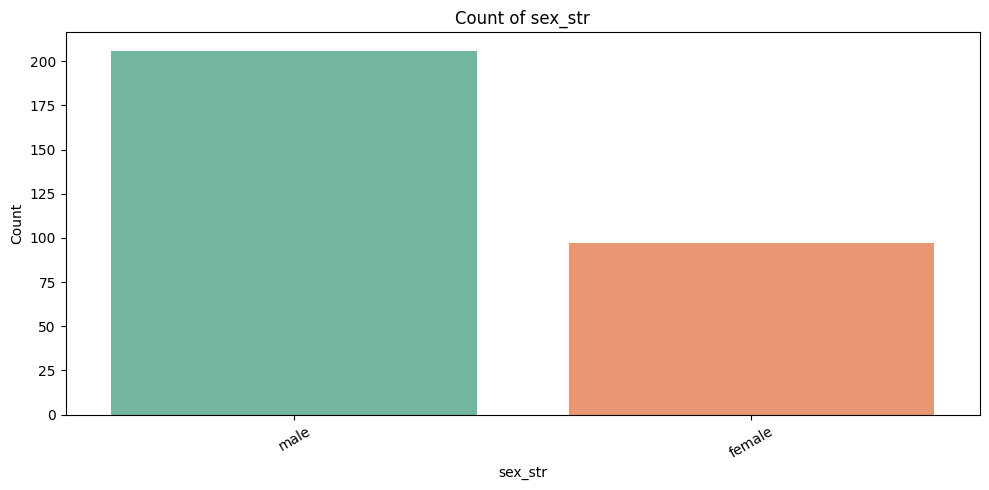

In [16]:
plot_feature_distribution_categorical(df, 'sex_str')

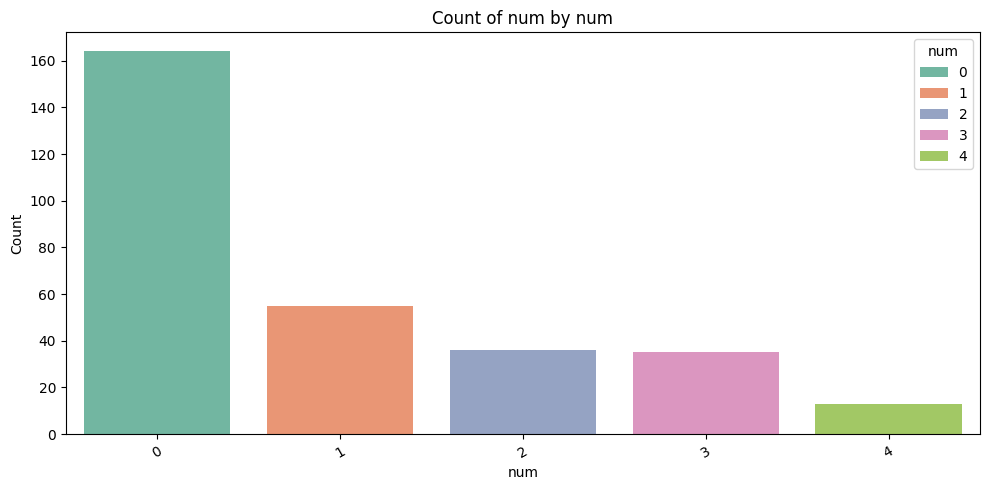

In [17]:
plot_feature_distribution_categorical(df, 'num', target='num')

The target variable ranges from 0 to 4, where 0 indicates no heart disease and values 1 through 4 represent increasing levels of disease severity. However, most studies and implementations based on this dataset simplify the problem into a binary classification task. Specifically, all non-zero values (1–4) are grouped together and treated as “disease present,” while 0 remains “no disease.” This transformation is widely adopted because the dataset is relatively small and the higher severity classes contain very few samples, which makes multi-class modeling unstable and prone to imbalance. Moreover, for most practical and clinical purposes, the key question is whether a patient has heart disease at all, rather than predicting the precise severity level. Converting the target variable to binary form therefore improves model reliability, simplifies interpretation, and aligns with the primary goal of identifying the presence of heart disease, which is especially relevant for fairness and counterfactual analysis.


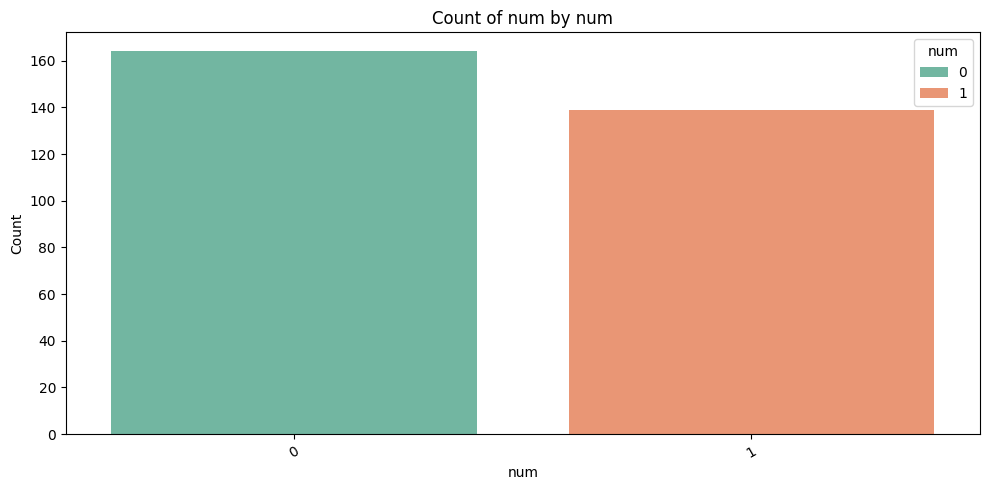

In [18]:
# Collapse multi-class target into binary
df['num'] = df['num'].apply(lambda x: 1 if x > 0 else 0)
plot_feature_distribution_categorical(df, 'num', target='num')

---

In [19]:
X = df.drop(columns=['num', 'sex_str'])
y = df['num']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
clf = RandomForestClassifier(random_state=42)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
print("Classification Report:")
print(classification_report(y_test, y_pred))

Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.82      0.89        33
           1       0.82      0.96      0.89        28

    accuracy                           0.89        61
   macro avg       0.89      0.89      0.89        61
weighted avg       0.90      0.89      0.89        61



In [20]:
df_test = pd.concat([X_test, y_test], axis=1)

In [21]:
from witwidget.notebook.visualization import WitConfigBuilder, WitWidget

# Convert your test data into the correct format
examples = X_test.values.tolist()

# Build configuration
config_builder = (
    WitConfigBuilder(examples, feature_names=X_test.columns.tolist())
    .set_target_feature('num')  # optional if you have the label in the data
    .set_model_type('classification')
    .set_custom_predict_fn(clf.predict_proba)
)

# Launch What-If Tool
WitWidget(config_builder)

TypeError: Descriptors cannot be created directly.
If this call came from a _pb2.py file, your generated code is out of date and must be regenerated with protoc >= 3.19.0.
If you cannot immediately regenerate your protos, some other possible workarounds are:
 1. Downgrade the protobuf package to 3.20.x or lower.
 2. Set PROTOCOL_BUFFERS_PYTHON_IMPLEMENTATION=python (but this will use pure-Python parsing and will be much slower).

More information: https://developers.google.com/protocol-buffers/docs/news/2022-05-06#python-updates